In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sklearn.preprocessing

In [2]:
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EmbeddingNetwork, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_dim)
        out, _ = self.gru(x)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

class RecoveryNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RecoveryNetwork, self).__init__()
        self.gru = nn.GRU(output_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, output_dim)
        out, _ = self.gru(x)
        out = self.linear(out)
        return out
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=False)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    
# class Generator(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers):
#         super().__init__()
#         self.rnn = nn.GRU(input_size, hidden_size, num_layers)
#         self.fc1 = nn.Linear(hidden_size, hidden_size)
#         self.norm1 = LayerNorm(hidden_size)
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.norm2 = LayerNorm(output_size)
#         self.dropout = nn.Dropout(0.1)
#         self.leakyrelu = nn.LeakyReLU()

#     def forward(self, x):
#         with torch.backends.cudnn.flags(enabled=False):
#             x, _ = self.rnn(x)
#             x = self.fc1(x)
#             x = self.norm1(x)
#             x = self.leakyrelu(x)
#             x = self.dropout(x)
#             x = self.fc2(x)
#             x = self.norm2(x)
#             return x

class Transformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout):
        super(Transformer, self).__init__()

        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, input):
        input = self.embedding(input)  # Embedding
        input = self.pos_encoder(input)  # Positional encoding
        output = self.encoder(input)  # Encoding
        output = self.decoder(output)  # Linear layer
        return output

# Define the positional encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
        
class Generator(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout):
        super(Generator, self).__init__()

        self.transformer = Transformer(input_size, output_size, num_layers, hidden_size, num_heads, dropout)
        
    def forward(self, noise):
        fake_samples = self.transformer(noise)
        return fake_samples
        
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        with torch.backends.cudnn.flags(enabled=False):
            x, _ = self.rnn(x)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.sigmoid(x)
            
            return x.squeeze()

In [3]:
# Set parameters
num_samples = 300
num_features = 6
phase_diff = 0.8

# Generate time steps
t = torch.linspace(0, 4 * math.pi, num_samples)

# Generate sine wave tensor
sine_wave = torch.zeros(num_samples, num_features)

for i in range(num_features):
    phase = i * phase_diff
    sine_wave[:, i] = 150 * torch.sin(t + phase) + 150
    
df = pd.DataFrame(sine_wave)
# create a MinMaxScaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fit and transform the dataframe
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Text(0, 0.5, 'Output')

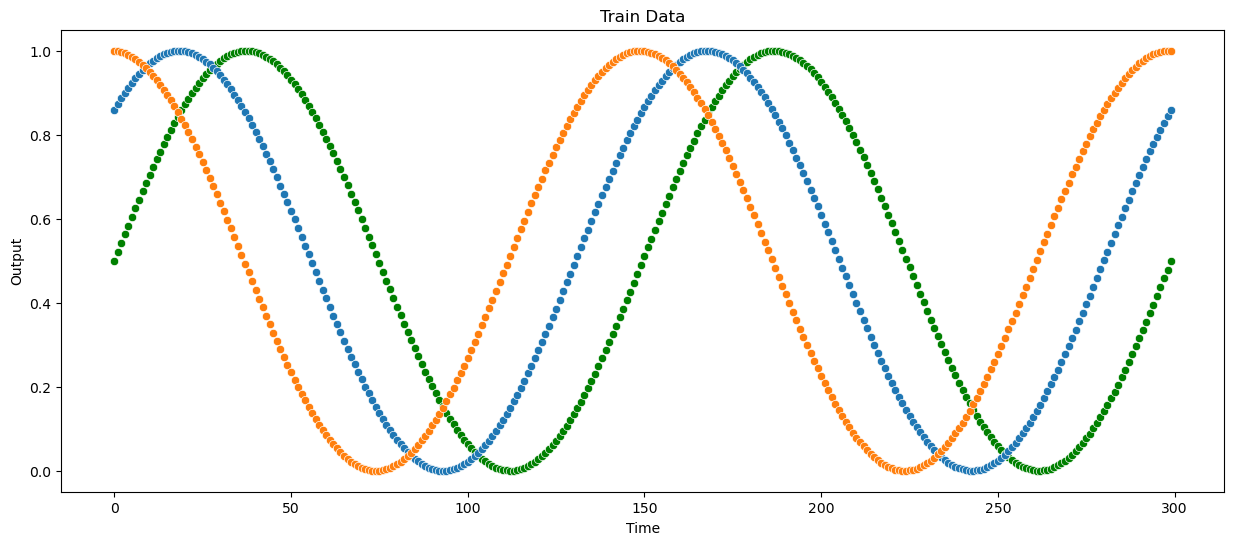

In [4]:
# This is the standardized training data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=scaled_df,x=scaled_df.index, y=scaled_df[0], color='g')
sns.scatterplot(data=scaled_df,x=scaled_df.index, y=scaled_df[1])
sns.scatterplot(data=scaled_df,x=scaled_df.index, y=scaled_df[2])
axes.set_title('Train Data')
axes.set_xlabel("Time")
axes.set_ylabel("Output")

In [5]:
# Specify length of test data, Takes first ## from csv
num_data = num_samples
df_test = scaled_df.iloc[:num_data]
# Input size and output size specify the shape of the tensor fed into the NN
input_size = len(df.columns)
output_size= len(df.columns)
# Hidden Layers and num Layers specify the size of the NN num_layers is arbitrary
hidden_size = 6
num_heads = 6
dropout = 0.1
num_layers = 3
# batch size is the size of data used in training
batch_size = 12
# Learning rate is the step size in optimizer
lr_g=0.0001
lr_d=0.0001
# Number of epochs  is the number of training cycles
num_epochs = 25

In [6]:
def embed_data(data, embedder):
    # Convert data to tensor
    data = torch.tensor(data, dtype=torch.float32)
    
    # Pass data through embedder
    embedded_data = embedder(data)
    
    # Convert output to numpy array
    embedded_data = embedded_data.detach().numpy()
    
    return embedded_data

In [7]:
# Convert data to numpy
data = df_test.to_numpy()

# # Convert numpy array to PyTorch tensor
data = torch.tensor(data, dtype=torch.float32)

# Create TimeSeriesDataset object
dataset = TensorDataset(data)

# Create DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size, shuffle=False)
class TimeSeriesDataset(Dataset):
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size
        
    def __len__(self):
        return len(self.data) - self.batch_size + 1
    
    def __getitem__(self, idx):
        window = self.data[idx : idx + self.batch_size]
        return torch.tensor(window, dtype=torch.float)

In [8]:
generator = Generator(input_size, output_size, num_layers, hidden_size, num_heads, dropout)
discriminator = Discriminator(input_size, hidden_size, num_layers)
embedder = EmbeddingNetwork(input_dim=input_size, hidden_dim=5, output_dim=output_size)
recovery_net = RecoveryNetwork(input_size, hidden_size, output_size)
embed_data(data, embedder)

C:\Users\16148\AppData\Local\Temp\ipykernel_14608\669831397.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


array([[0.62795365, 0.5265263 , 0.6132167 , 0.49842426, 0.5927356 ,
        0.4955205 ],
       [0.65370905, 0.5301332 , 0.6260447 , 0.50198126, 0.59706783,
        0.49282402],
       [0.6732494 , 0.5329602 , 0.6328927 , 0.5058292 , 0.601337  ,
        0.49180108],
       ...,
       [0.70430386, 0.5349981 , 0.6566453 , 0.5350928 , 0.6143083 ,
        0.50514615],
       [0.70653003, 0.53671134, 0.6551875 , 0.53391975, 0.6139758 ,
        0.5045783 ],
       [0.7086838 , 0.53835803, 0.65366703, 0.5327199 , 0.6136633 ,
        0.5039892 ]], dtype=float32)

In [9]:
# def train_gan(embedder, generator, discriminator, data, num_epochs, batch_size, lr_g=0.001, lr_d=0.001, critic_iters=2):
#     # Set models to train mode
#     embedder.train()
#     generator.train()
#     discriminator.train()

#     # Define optimizers
#     optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
#     optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

#     # Define loss function
#     adversarial_loss = nn.BCELoss()
    
#     z_dim = 5
#     clip_value = 5
    
#     for epoch in range(num_epochs):
#         for i in range(len(data)//batch_size):
#             # Load batch of real samples
#             real_samples = data[i*batch_size:(i+1)*batch_size]

#             # Generate noise
#             noise = torch.randn(batch_size, z_dim)

#             # Generate fake samples
#             fake_samples = generator(embedder(noise)).detach()

#             # Train discriminator
#             for _ in range(critic_iters):
#                 optimizer_d.zero_grad()
                
#                 # Real samples
#                 real_labels = torch.ones(batch_size)
#                 real_output = discriminator(real_samples)
#                 d_real_loss = adversarial_loss(real_output, real_labels)

#                 # Fake samples
#                 fake_labels = torch.zeros(batch_size)
#                 fake_output = discriminator(fake_samples)
#                 d_fake_loss = adversarial_loss(fake_output, fake_labels)

#                 # Compute total loss and backpropagate
#                 d_loss = d_real_loss + d_fake_loss
#                 d_loss.backward()
#                 optimizer_d.step()

#                 # Clip discriminator parameters
#                 for p in discriminator.parameters():
#                     p.data.clamp_(-clip_value, clip_value)

#             # Train generator
#             optimizer_g.zero_grad()
            
#             # Generate new fake samples
#             noise = torch.randn(batch_size, z_dim)
#             fake_samples = generator(embedder(noise))
            
#             # Compute generator loss and backpropagate
#             fake_labels = torch.ones(batch_size)
#             fake_output = discriminator(fake_samples)
#             g_loss = adversarial_loss(fake_output, fake_labels)
#             g_loss.backward()
#             optimizer_g.step()

#         print(f"Epoch {epoch+1}/{num_epochs} | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")

#     # Return generator and discriminator models
#     return generator, discriminator

In [10]:
def train_gan(embedder, generator, discriminator, dataloader, num_epochs, batch_size, lr_g=0.001, lr_d=0.001, critic_iters=2):
    # Set models to train mode
    embedder.train()
    generator.train()
    discriminator.train()

    # Define optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

    # Define loss function
    adversarial_loss = nn.BCELoss()
    
    z_dim = 6
    clip_value = 5
    
    for epoch in range(num_epochs):
        for i, real_samples in enumerate(dataloader):
            # Load batch of real samples
            real_samples = torch.stack(real_samples, dim=0)

            # Train discriminator
            for critic_iter in range(critic_iters):
                # Generate noise
                noise = torch.randn(batch_size, z_dim)

                # Generate fake samples
                fake_samples = generator(embedder(noise)).detach()
            
                
                
                # Real samples
                real_labels = torch.ones(batch_size)
                real_output = discriminator(real_samples)
                

                # Fake samples
                fake_labels = torch.zeros(batch_size)
                fake_output = discriminator(fake_samples)
                

                # Compute total loss and backpropagate
                d_loss = -torch.mean(real_output) + torch.mean(fake_output)
                
                # Gradient penalty
                eps = torch.rand(batch_size, 6)
                interpolated = eps * real_samples + (1 - eps) * fake_samples
                interpolated.requires_grad = True
                interpolated_output = discriminator(interpolated)
                gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated,
                                                grad_outputs=torch.ones_like(interpolated_output),
                                                create_graph=True, retain_graph=True)[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += 10 * gradient_penalty
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

                # Clip discriminator parameters
                for p in discriminator.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # Train generator
            optimizer_g.zero_grad()
            
            # Generate new fake samples
            noise = torch.randn(batch_size, z_dim)
            fake_samples = generator(embedder(noise))
            
            # Compute generator loss and backpropagate
            fake_labels = torch.ones(batch_size)
            fake_output = discriminator(fake_samples)
            g_loss = -torch.mean(fake_output)
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Generator Loss: {g_loss.item():.6f} | Discriminator Loss: {d_loss.item():.6f}")

    # Return generator and discriminator models
    return generator, discriminator

In [11]:
train_gan(embedder, generator, discriminator, dataloader, num_epochs, batch_size, lr_g=0.001, lr_d=0.001, critic_iters=2)


Epoch 1/25 | Generator Loss: -0.549945 | Discriminator Loss: 8.445979
Epoch 2/25 | Generator Loss: -0.597750 | Discriminator Loss: 9.788210
Epoch 3/25 | Generator Loss: -0.641989 | Discriminator Loss: 9.127314
Epoch 4/25 | Generator Loss: -0.672940 | Discriminator Loss: 5.244369
Epoch 5/25 | Generator Loss: -0.656873 | Discriminator Loss: 10.086740
Epoch 6/25 | Generator Loss: -0.665829 | Discriminator Loss: 1.033092
Epoch 7/25 | Generator Loss: -0.648024 | Discriminator Loss: 10.046234
Epoch 8/25 | Generator Loss: -0.627724 | Discriminator Loss: 10.006673
Epoch 9/25 | Generator Loss: -0.602023 | Discriminator Loss: 10.080618
Epoch 10/25 | Generator Loss: -0.580425 | Discriminator Loss: 8.981804
Epoch 11/25 | Generator Loss: -0.579608 | Discriminator Loss: 9.978200
Epoch 12/25 | Generator Loss: -0.532803 | Discriminator Loss: 8.976656
Epoch 13/25 | Generator Loss: -0.557795 | Discriminator Loss: 7.249081
Epoch 14/25 | Generator Loss: -0.535845 | Discriminator Loss: 8.277557
Epoch 15/25

(Generator(
   (transformer): Transformer(
     (embedding): Linear(in_features=6, out_features=6, bias=True)
     (pos_encoder): PositionalEncoding(
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-2): 3 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
           )
           (linear1): Linear(in_features=6, out_features=6, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=6, out_features=6, bias=True)
           (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (decoder): Linear(in_features=6, out_features=6, bias

<AxesSubplot:ylabel='0'>

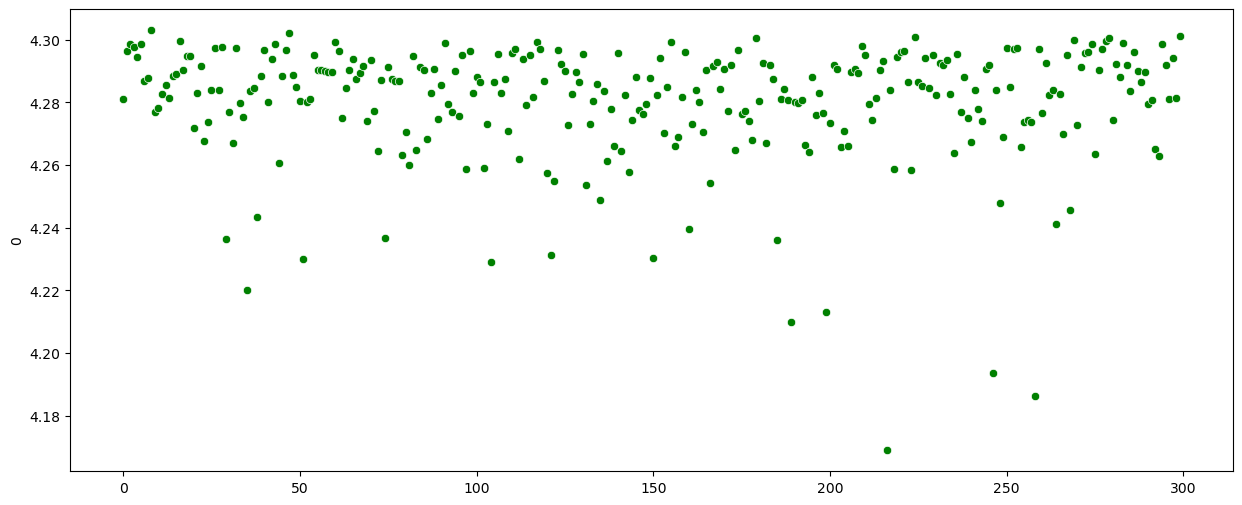

In [16]:
# Generate the new data, size is the number of time points
z = torch.randn(size=(300, input_size))
# struck_noise = tensor.to(device)
# z = struck_noise
with torch.no_grad():
    fake_samples = generator(z)

# This is what the Generated time series looks like
df_gen = pd.DataFrame(fake_samples[0])

# # Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[0], color='g')

# axes.set_title('Unstructured Noise Data')
# axes.set_xlabel("Time")
# axes.set_ylabel("Output")
# # plt.ylim(1.0, 1.5)

In [14]:
fake_samples[0]


tensor([[ 4.2175,  3.4888, -2.0569,  2.8668,  4.4337,  4.5055],
        [ 4.2936,  3.5660, -2.0801,  2.8696,  4.5223,  4.6698],
        [ 4.2084,  3.5196, -2.0552,  2.8206,  4.4696,  4.6864],
        ...,
        [ 4.2894,  3.5764, -2.0711,  2.8490,  4.5244,  4.6843],
        [ 4.2704,  3.5609, -2.0801,  2.8664,  4.5136,  4.6837],
        [ 4.2780,  3.5737, -2.0680,  2.8504,  4.5255,  4.6740]])